In [117]:
from lightkurve import search_targetpixelfile

import matplotlib.pyplot as plt
%matplotlib inline

from altaipony.flarelc import FlareLightCurve

import os
import copy

import numpy as np
import pandas as pd

from funcs.custom_detrending import custom_detrending, iteratively_remove_sines
from funcs.funcs import read_custom_aperture_lc

import astropy.units as u

from scipy import optimize

CWD = "/".join(os.getcwd().split("/")[:-1])

c = 10#12#
TIC = 44984200#277539431 #

### Create a light curve mosaic from individual pixel light curves

In [ ]:
# if you need to create the tiles first, you have to do it manually
tpfl = search_targetpixelfile(f"TIC {TIC}", sector=c)
tpf = tpfl.download()
tpf.interact()

In [ ]:
paths = ! ls ../multiperiod_flares/277539431_12/single_pixel_LCs/


fig, ax = plt.subplots(nrows=5,ncols=5, figsize=(20,20), sharex=True)

for p in paths:
    i = 4-int(p[0])+1
    j = int(p[1])
    flc = search.open(f"{CWD}/weird_feature/{p}").get_lightcurve("FLUX")
    flc = FlareLightCurve(time=flc.time, flux=flc.flux, 
                      flux_err=flc.flux_err, cadenceno=flc.cadenceno, targetid=flc.targetid)

    #flcd = custom_detrending(flc)
    #ax[i][j].plot(flcd.time,flcd.detrended_flux/np.nanmedian(flcd.detrended_flux))
    ax[i][j].plot(flc.time,flc.flux/np.nanmedian(flc.flux))
    ax[i][j].set_xlim(1640,1644)
    #rel = np.nanmean(flcd.detrended_flux_err / flcd.detrended_flux)
    rel = np.nanmean(flc.flux_err / flc.flux)
    ax[i][j].set_ylim(.9-3*rel,1.2 + 8*rel)
    
plt.subplots_adjust(hspace=0.,wspace=0)
#plt.savefig(f"{CWD}/plots/weird_feature_nodet_relerrasymmetric.png",dpi=300)

### Just show the flare

/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/tessenv/lib/python3.6/site-packages/ipykernel_launcher.py:8: ResourceWarning: unclosed file <_io.FileIO name='/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/custom_aperture/131ca_tess2019091210055-s0010-0000000044984200-0000-s_lc.fits' mode='rb' closefd=True>
  


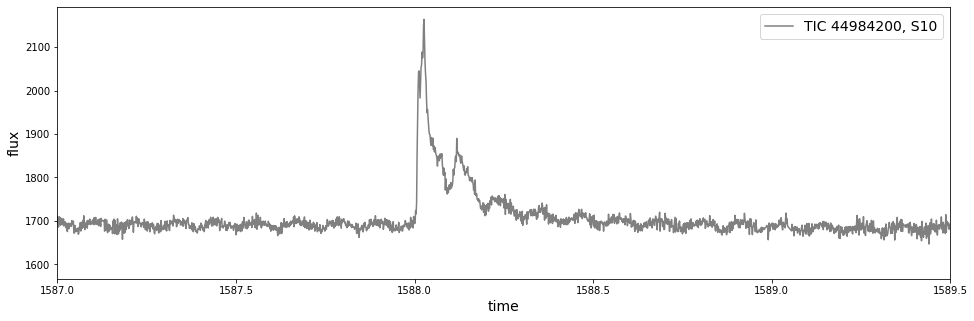

In [118]:
if TIC == 44984200:
    p = "131ca_tess2019091210055-s0010-0000000044984200-0000-s_lc.fits"
    dt = (1587,1589.5)
elif TIC == 277539431:
    p = "170ca_tess2019102314425-s0012-0000000277539431-0000-s_lc.fits"
    dt = (1641,1643.5)

flc = read_custom_aperture_lc(f"{CWD}/custom_aperture/{p}")

plt.figure(figsize=(16,5))

plt.plot(flc.time, flc.flux, c="grey",label=f"TIC {TIC}, S{c}")
#flcd = iteratively_remove_sines(flc)

#plt.plot(flcd.time, flcd.detrended_flux)

plt.xlim(*dt)
plt.xlabel("time",fontsize=14)
plt.ylabel("flux",fontsize=14)
plt.legend(fontsize=14);
plt.savefig(f"{CWD}/multiperiod_flares/{TIC}_{c}/plots/{TIC}_s{c}_lightcurve.png",dpi=300)

### De-trend the light curve and show the overfitting

Found peak in periodogram at  8.83810300366823 1 / d
SNR at  4.843561726148278
Found peak in periodogram at  0.5 1 / d
SNR at  2.3907309132823014
Window lengths:  [2547, 369]
Do last SavGol round.


(1587, 1589.5)

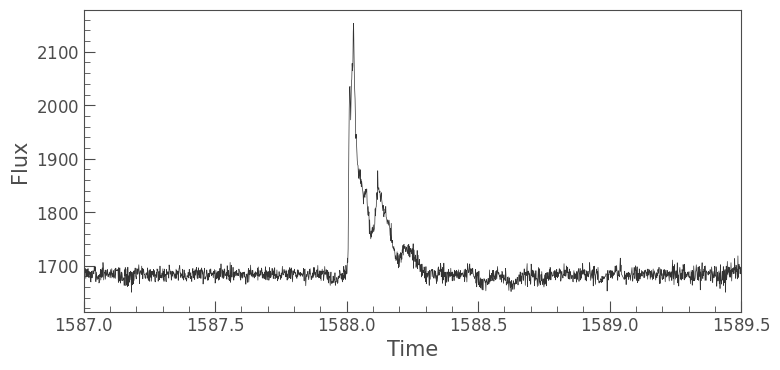

In [119]:
flcc = copy.deepcopy(flc)
flcc = custom_detrending(flcc)
flcc.flux[:] = flcc.detrended_flux
flcc.plot()

plt.xlim(*dt)

### Find the modulation period

modulation period:  2.712461696095165 h


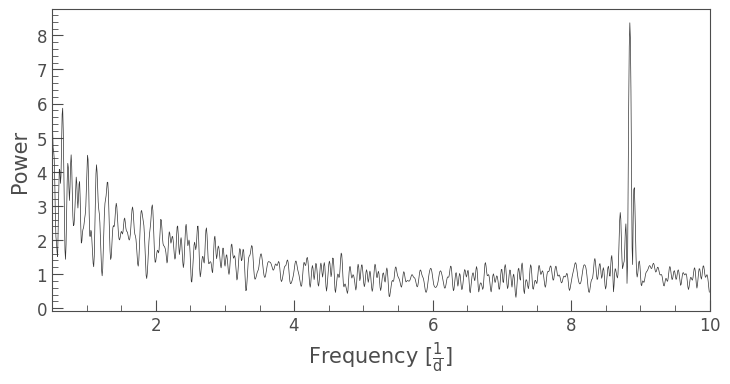

In [120]:
pg = flc.remove_nans().to_periodogram(freq_unit=1/u.d,
                                          maximum_frequency=10,
                                          minimum_frequency=0.5)
pg.plot()
plt.xlim(.5, 10)
period = (1 / pg.frequency_at_max_power).to("h")
plt.savefig(f"{CWD}/multiperiod_flares/{TIC}_{c}/plots/{TIC}_s{c}_periodogram.png",dpi=300)
print("modulation period: ", period)

## Fit a sinusoidal modulation

In [121]:
def cosine(x, a, b, c, d):
        return a * np.cos(b * x + c) + d 
    
flck = copy.deepcopy(flc)
cond = np.invert(np.isnan(flck.time)) & np.invert(np.isnan(flck.flux)) 
p, p_cov = optimize.curve_fit(cosine, flck.time[cond], flck.flux[cond],
                                          p0=[np.nanstd(flck.flux),
                                          2*np.pi*pg.frequency_at_max_power.value,
                                          0, np.nanmean(flck.flux)])
#flck.flux = np.nanmean(flck.flux) + flck.flux-cosine(flck.time, p[0], p[1], p[2], p[3])
rel_amplitude = p[0] / np.nanmedian(flck.flux)
print(f"Relative amplitude of modulation: {rel_amplitude:.1e}")

Relative amplitude of modulation: 4.9e-03


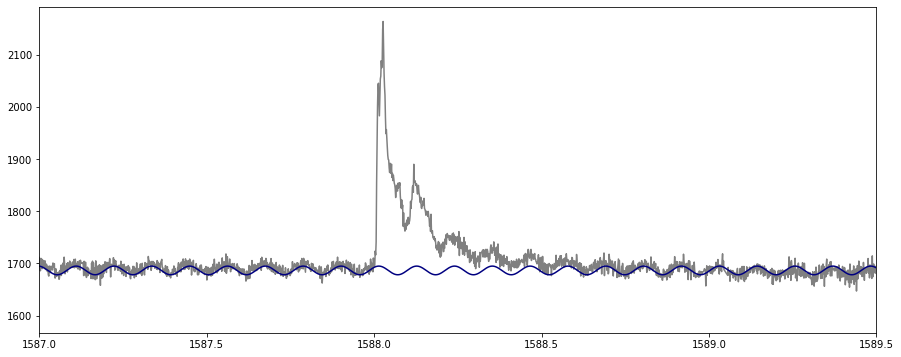

In [122]:
plt.figure(figsize=(15,6))
plt.plot(flck.time, flck.flux,c="grey")
#plt.plot(flck.time, np.nanmean(flck.flux) + flck.flux - cosine(flck.time, p[0], p[1], p[2], p[3]))
plt.plot(flck.time, cosine(flck.time, p[0], p[1], p[2], p[3]), c="navy")
plt.xlim(*dt)
plt.savefig(f"{CWD}/multiperiod_flares/{TIC}_{c}/plots/{TIC}_s{c}_sinusoidal.png",dpi=300)

### Find flares

In [123]:
flcd = copy.deepcopy(flc)
flcd = custom_detrending(flcd)
flcd = flcd.find_flares()
flcd.flares

Found peak in periodogram at  8.83810300366823 1 / d
SNR at  4.843561726148278
Found peak in periodogram at  0.5 1 / d
SNR at  2.3907309132823014
Window lengths:  [2547, 369]
Do last SavGol round.


Found 1 candidate(s) in the (0,7641) gap.
Found 3 candidate(s) in the (7641,15364) gap.
/home/ekaterina/Documents/001_Science/TESS_UCDs/TESS_UCD_flares/tessenv/lib/python3.6/site-packages/pandas/core/frame.py:7138: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


,ampl_rec,cstart,cstop,ed_rec,ed_rec_err,istart,istop,total_n_valid_data_points,tstart,tstop
0,0.089763,247769,247778,59.594056,1.515027,328,337,15364.0,1571.580838,1571.593338
1,0.278765,259595,259724,1463.513695,5.775031,9856,9985,15364.0,1588.005660,1588.184824
2,0.033307,259743,259771,91.440830,3.098281,10004,10032,15364.0,1588.211213,1588.250101
3,0.065148,262377,262380,14.651663,0.617661,12629,12632,15364.0,1591.869490,1591.873656


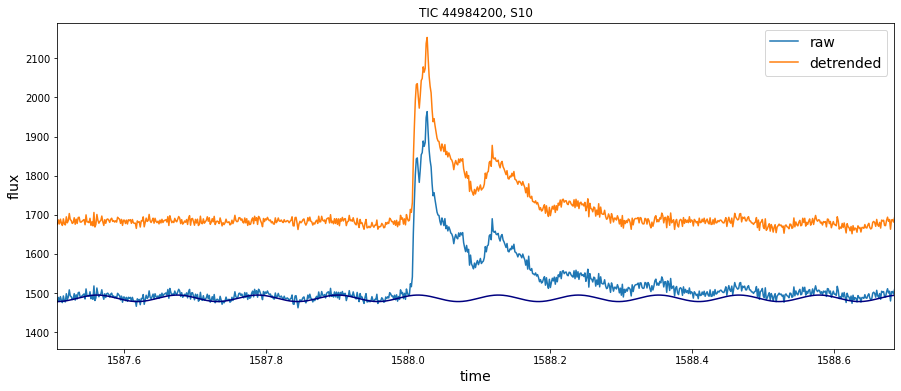

In [124]:
plt.figure(figsize=(15,6))
plt.title(f"TIC {TIC}, S{c}")
plt.plot(flc.time, flc.flux-200, label="raw")
plt.plot(flcd.time,flcd.detrended_flux, label="detrended")
plt.plot(flck.time, cosine(flck.time, p[0], p[1], p[2], p[3])-200, c="navy")
plt.xlabel("time",fontsize=14)
plt.ylabel("flux",fontsize=14)
plt.legend(fontsize=14)
f = flcd.flares.iloc[1]
plt.xlim(f.tstart-.5,f.tstop+.5);
#plt.xlim()

### Fit a classic flare template

In [125]:
durdict = {44984200 : (5,6),
           277539431 : (2.5,3)}

In [126]:
dur = (durdict[TIC][0] * period.to("d").value,
       durdict[TIC][1] * period.to("d").value)
dur

(0.5650961866864926, 0.6781154240237912)

In [127]:
CWD = "/".join(os.getcwd().split("/")[:-1])
respath = f"{CWD}/flare_tables/2019_11_18_TESSUCDs_flares.csv"
df = pd.read_csv(respath)
f = df
df["x"] = df.tstop - df.tstart
df = df.sort_values(by="x")
x = df.x.values
#x = f.ed_rec.values
y = df.ed_rec.values

def func(x, a, b):
    return a * np.power(x , b)
popt, pcov = optimize.curve_fit(func, x, y)

EDest = func(dur[0], *popt),func(dur[1], *popt)

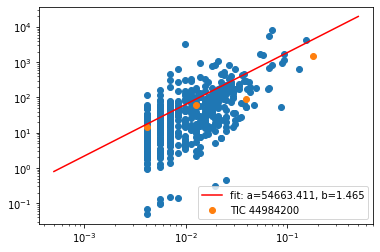

In [128]:
plt.scatter(x, y)
#plt.scatter(flcd.flares.ed_rec, flcd.flares.ampl_rec)
plt.scatter(flcd.flares.tstop-flcd.flares.tstart,
            flcd.flares.ed_rec, label=f"TIC {TIC}")
plt.xscale("log")
plt.yscale("log")

a=np.array([5e-4,5e-3,5e-2,5e-1])
plt.plot(a, func(a, *popt), 'r-',
         label='fit: a=%5.3f, b=%5.3f' % tuple(popt))
plt.legend();

### Fit a flare template

In [129]:
tstartdict = {44984200:[1588.03, (.5,.8)],
              277539431:[1641.835, (.9,1.7)]}

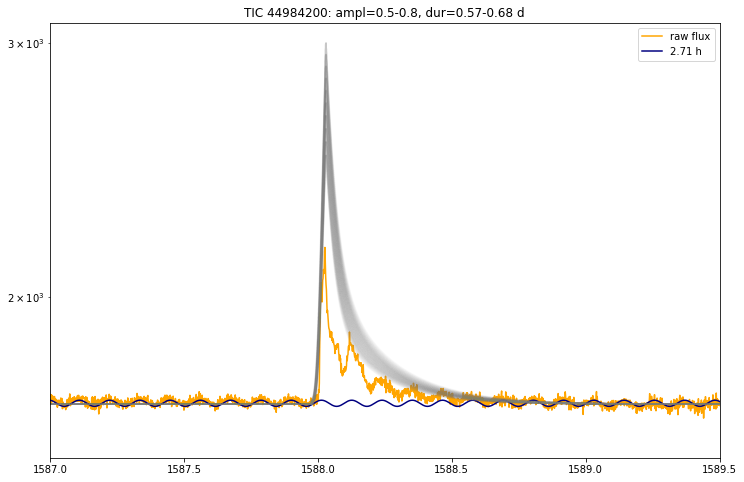

In [130]:
from altaipony.fakeflares import aflare
plt.figure(figsize=(12,8))
plt.plot(flc.time, flc.flux, c="orange", label="raw flux");
plt.plot(flck.time, cosine(flck.time, p[0], p[1], p[2], p[3]), c="navy", label=f"{period:.2f}")
f = flcd.flares.iloc[3]
plt.xlim(*dt);
plt.yscale("log")
#plt.ylim(1.36e5,1.4e5)
#plt.xlim(298200,298600)
#plt.xlim(1641.81,1644)
EDs = []
ampl = tstartdict[TIC][1]
for a in np.linspace(ampl[0],ampl[1],10):
    for d in np.linspace(dur[0],dur[1],10):
        plt.plot(flcd.time, 
                 flcd.it_med*aflare(flcd.time, tstartdict[TIC][0] , d/6, a,) + flcd.it_med, 
                 c="grey", alpha=.05)
        x = flcd.time * 60.0 * 60.0 * 24.0
        integral = np.sum(np.diff(x) * aflare(flcd.time, tstartdict[TIC][0] , d/6, a,)[:-1])
        EDs.append(integral)
plt.title(f"TIC {TIC}: ampl={ampl[0]}-{ampl[1]}, dur={dur[0]:.2f}-{dur[1]:.2f} d")
plt.legend();
plt.savefig(f"{CWD}/multiperiod_flares/{TIC}_{c}/plots/{TIC}_s{c}_flarefit.png",dpi=300)

In [131]:
eds = np.array(EDs)
medED, stdED = np.median(eds), np.std(eds)

# Summary

In [132]:
print(f"TIC {TIC}, sector {c}:\n"\
      f"Modulation period: {period:.2f}\n"\
      f"Estimated ED from duration-amplitude relation: {EDest[0]:.0f}-{EDest[1]:.0f} s\n"\
      f"Estimated ED from flare fit: {medED:.0f}+/-{stdED:.0f} s\n"\
      f"Relative amplitude of modulation: {rel_amplitude:.1e}")

TIC 44984200, sector 10:
Modulation period: 2.71 h
Estimated ED from duration-amplitude relation: 23689-30942 s
Estimated ED from flare fit: 5302+/-843 s
Relative amplitude of modulation: 4.9e-03
